In [2]:
import sys
import os
from collections import defaultdict
import sacrebleu

temp_path = 'ende_{}_wmt14.en-de.transformer.para_ft'
dfs_path = temp_path.format('dfstopk')
beam_path = temp_path.format('beam')
beam_size = 10

In [3]:
def read_split_files(file_path, beam_size):
    all_lines = dict()
    for file in os.listdir(file_path):
        cur_path = os.path.join(file_path, file)
        with open(cur_path, 'r') as f:
            lines = f.readlines()
        num_suffix = file.split('.')[-1]
        all_lines[int(num_suffix)] = lines
    max_range = max([int(key) for key in all_lines])
    assert max_range + 1 == len(all_lines)

    ret = defaultdict(list)
    for i in range(max_range+1):
        offset = beam_size * i
        for line in all_lines[i]:
            splits = line.strip().split('|||')
            assert len(splits) == 3
            idx, sent, score = splits
            true_idx = offset + int(idx)
            ret[true_idx].append((float(score), sent.strip()))
    return ret

In [4]:
# call delbpe
import subprocess

def call_delbpe(input_dir):
    output_dir = input_dir + '.delbpe'
    print(output_dir)
    subprocess.run(['mkdir', '-p', output_dir])
    for file in os.listdir(input_dir):
        if not file.endswith('delbpe'):
            abs_path = os.path.join(input_dir, file)
            out_path = os.path.join(output_dir, file)
            subprocess.run(['bash', 'delbpe.sh', abs_path])
            subprocess.run(['mv', abs_path+'.delbpe', out_path])
            
    return output_dir

In [5]:
# call delbpe
import subprocess

def call_detok(input_dir):
    output_dir = input_dir + '.detok'
    print(output_dir)
    subprocess.run(['mkdir', '-p', output_dir])
    for file in os.listdir(input_dir):
        if not file.endswith('detok'):
            abs_path = os.path.join(input_dir, file)
            out_path = os.path.join(output_dir, file)
            f1 = open(abs_path, 'r')
            f2 = open(out_path, 'w')
            subprocess.run(['perl', 'detokenizer.perl'], stdin=f1, stdout=f2)
            f1.close()
            f2.close()
#             subprocess.run(['mv', abs_path+'.delbpe', ])
            
    return output_dir

In [6]:
delbpe_beam_path = call_delbpe(beam_path)
delbpe_dfs_path = call_delbpe(dfs_path)

ende_beam_wmt14.en-de.transformer.para_ft.delbpe
ende_dfstopk_wmt14.en-de.transformer.para_ft.delbpe


In [7]:
detok_delbpe_beam_path = call_detok(delbpe_beam_path)
detok_delbpe_dfs_path = call_detok(delbpe_beam_path)

ende_beam_wmt14.en-de.transformer.para_ft.delbpe.detok
ende_beam_wmt14.en-de.transformer.para_ft.delbpe.detok


In [45]:
beam_outputs = read_split_files(beam_path, beam_size)
dfs_outputs = read_split_files(dfs_path, beam_size)

In [9]:
def read(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]
    return lines
ref_file = './test.de.tok.detok'
refs = read(ref_file)

In [10]:
len(refs)

3003

In [29]:
def score_all_outputs(output_dict, refs):
    scores = []
    for idx in output_dict:
        cur_ref = refs[idx]
        candidates = output_dict[idx]
        candidates = [item[1] for item in candidates]
        cur_scores = [sacrebleu.sentence_bleu(item, cur_ref).score for item in candidates]
        scores.append(cur_scores)
    return scores
# beam_scores = score_all_outputs(beam_outputs, refs)

In [12]:
all_scores = []
for i in range(len(beam_scores)):
    for item in beam_scores[i]:
        all_scores.append(item.score)
print(sum(all_scores) / len(all_scores))

18.250411330999558


In [13]:
def get_top1(outputs):
    ret = [None] * len(outputs)
    for key in outputs:
        ret[key] = outputs[key][0][1]
    return ret
def write_file(sents, file):
    with open(file, 'w') as f:
        for sent in sents:
            f.write(sent + '\n')
beam_top1s = get_top1(beam_outputs)
write_file(beam_top1s, 'beam.outs')

In [14]:
beam_scores[50][1].score

16.883931426309903

In [107]:
print(len(beam_outputs))
print(len(dfs_outputs))

3003
3003


In [18]:
print(beam_outputs[0])

[(-3.93865, 'Gutach : Erhöhung der Sicherheit für Fußgänger'), (-4.273254, 'Gutach : Mehr Sicherheit für Fußgänger'), (-4.321206, 'Gutach : Erhöhte Sicherheit für Fußgänger'), (-4.95942, 'Reichweite : Erhöhung der Sicherheit für Fußgänger'), (-5.522714, 'Gutgang : Erhöhung der Sicherheit für Fußgänger'), (-5.709036, 'Bach : Erhöhung der Sicherheit für Fußgänger'), (-5.715024, 'Leistung : Erhöhung der Sicherheit für Fußgänger'), (-5.885941, 'Gutachter : Erhöhung der Sicherheit für Fußgänger'), (-6.366059, 'Ziel : Erhöhung der Sicherheit für Fußgänger'), (-7.154575, 'Gutach : Die Sicherheit für Fußgänger')]


In [46]:
import copy
def process_text_in_moses_format(output_dict, func):
    all_texts = []
    for i in range(len(output_dict)):
        for j in range(len(output_dict[i])):
            all_texts.append(output_dict[i][j][1])
        
    import tempfile
    # write to temp file
    f_temp = tempfile.NamedTemporaryFile(mode='w', encoding='utf8', delete=False)
    temp_name = f_temp.name
    for line in all_texts:
        f_temp.write(line+'\n')
    f_temp.close()
    ret_file_name = func(temp_name)
    with open(ret_file_name, 'r', encoding='utf8') as f:
        lines = f.readlines()
    ret_texts = [line.strip() for line in lines]
    
    ret = copy.deepcopy(output_dict)
    k = 0
    # put back
    for i in range(len(ret)):
        for j in range(len(ret[i])):
            ret[i][j] = (ret[i][j][0], ret_texts[k])
            k += 1
    return ret

def call_delbpe(file_name):
    subprocess.run(['bash', 'delbpe.sh', file_name])
    return file_name + '.delbpe'

def call_detok(file_name):
    out_path = file_name + '.detok'
    f1 = open(file_name, 'r')
    f2 = open(out_path, 'w')
    subprocess.run(['perl', 'detokenizer.perl'], stdin=f1, stdout=f2)
    return out_path

def call_delbpe_and_detok(file_name):
    f1 = call_delbpe(file_name)
    f2 = call_detok(f1)
    return f2

dbpe_detok_beam_outputs = process_text_in_moses_format(beam_outputs, call_delbpe_and_detok)

In [47]:
beam_top1s = get_top1(dbpe_detok_beam_outputs)
print(sacrebleu.corpus_bleu(beam_top1s, [refs]))

BLEU = 26.70 57.3/32.3/20.4/13.5 (BP = 1.000 ratio = 1.036 hyp_len = 64948 ref_len = 62719)


In [48]:
dbpe_detok_dfstopk_outputs = process_text_in_moses_format(dfs_outputs, call_delbpe_and_detok)

In [50]:
dfs_top1s = get_top1(dbpe_detok_dfstopk_outputs)
print(sacrebleu.corpus_bleu(dfs_top1s, [refs]))
write_file(dfs_top1s, 'dfs.outs')

BLEU = 26.70 57.3/32.3/20.4/13.5 (BP = 1.000 ratio = 1.036 hyp_len = 64948 ref_len = 62719)


In [30]:
beam_scores = score_all_outputs(dbpe_detok_beam_outputs, refs)
dfstopk_scores = score_all_outputs(dbpe_detok_dfstopk_outputs, refs)

In [38]:
from collections import defaultdict
import numpy as np
def collect_pos_stats(scores):
    pos_scores = defaultdict(list)
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            pos_scores[j].append(scores[i][j])
    for key in pos_scores:
        pos_scores[key] = np.array(pos_scores[key])
        pos_scores[key] = {
            'mean': np.mean(pos_scores[key]),
            'std': np.std(pos_scores[key]),
        }
    return pos_scores

beam_pos_scores = collect_pos_stats(beam_scores)
dfs_pos_scores = collect_pos_stats(dfstopk_scores)

In [40]:
print(dfs_pos_scores)

defaultdict(<class 'list'>, {0: {'mean': 20.74970116011649, 'std': 21.597381729234026}, 1: {'mean': 19.633633456812728, 'std': 20.436568823192456}, 2: {'mean': 19.726919453173267, 'std': 20.441516902652868}, 3: {'mean': 19.601352199124246, 'std': 20.288931039242172}, 4: {'mean': 19.09898318279514, 'std': 19.78601045340043}, 5: {'mean': 18.9456454764055, 'std': 19.671050240776243}, 6: {'mean': 19.008323678737344, 'std': 19.808169985374946}, 7: {'mean': 18.72328988844938, 'std': 19.66063263137844}, 8: {'mean': 18.390385084119487, 'std': 19.124830412555717}, 9: {'mean': 18.059199669509955, 'std': 19.063192236516006}})


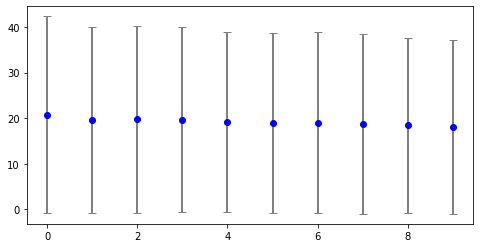

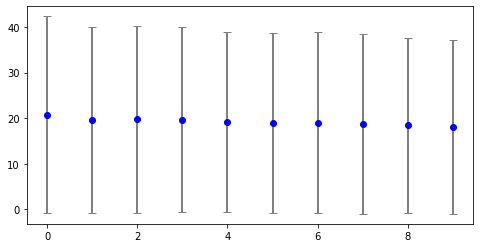

In [44]:
from matplotlib import pyplot as plt

def plot_errorbar(stats_dict):
    fig,ax=plt.subplots(figsize=(8,4))
    keys = stats_dict.keys()
    means = [stats_dict[key]['mean'] for key in keys]
    errs = [stats_dict[key]['std'] for key in keys]

    ax.errorbar(keys, means,
                yerr=errs,\
                fmt="o",color="blue",ecolor='grey',elinewidth=2,capsize=4)
#     ax.set_xticklabels(col,rotation=45) #设置x轴刻度标签，并使其倾斜45度，不至于重叠

plot_errorbar(dfs_pos_scores)
plot_errorbar(beam_pos_scores)

In [54]:
def beam_match_dfs(beam_outputs, dfs_outputs):
    check_dict = dict()
    for key in dfs_outputs:
        texts = [item[1] for item in dfs_outputs[key]]
        check_dict[key] = set(texts)
    # check beam outputs
    n_cover = 0
    n_cnt = 0
    for key in beam_outputs:
        for item in beam_outputs[key]:
            n_cnt += 1
            txt = item[1]
            if txt in check_dict[key]:
                n_cover += 1
    return n_cover / n_cnt

print(beam_match_dfs(beam_outputs, dfs_outputs))

1.0


In [55]:
beam_top1s = get_top1(dbpe_detok_beam_outputs)
dfs_top1s = get_top1(dbpe_detok_dfstopk_outputs)
write_file(dfs_top1s, 'dfs.outs')
write_file(beam_top1s, 'beam.outs')


### analyze baseline model outputs

In [2]:
import sys
import os
from collections import defaultdict
import sacrebleu
temp_path = 'ende_{}_wmt14.en-de.transformer'
dfs_path = temp_path.format('dfstopk')
beam_path = temp_path.format('beam')
beam_size = 5

In [3]:
def read_split_files(file_path, beam_size):
    all_lines = dict()
    for file in os.listdir(file_path):
        cur_path = os.path.join(file_path, file)
        with open(cur_path, 'r') as f:
            lines = f.readlines()
        num_suffix = file.split('.')[-1]
        all_lines[int(num_suffix)] = lines
    max_range = max([int(key) for key in all_lines])
    assert max_range + 1 == len(all_lines)

    ret = defaultdict(list)
#     print(max_range)
    for i in range(max_range+1):
        offset = beam_size * i
#         print(offset)
        for line in all_lines[i]:
            try:
                splits = line.strip().split('|||')
                assert len(splits) == 3
            except:
                print(i)
                print(line)
                print(splits)
            idx, sent, score = splits
            true_idx = offset + int(idx)
            ret[true_idx].append((float(score), sent.strip()))
    return ret
beam_outputs = read_split_files(beam_path, beam_size)
dfs_outputs = read_split_files(dfs_path, beam_size)

In [4]:
dfs_outputs[1]

[(-9.055887, ''),
 (-11.160469, 'Nach ca .'),
 (-12.457957, 'Sie liegen ca .'),
 (-12.568825, 'ca .'),
 (-12.734378, 'Die ca .'),
 (-12.925178, 'Nach dem 2 .'),
 (-13.185588, 'Im 1 .'),
 (-13.254346, 'Sie liegen nicht ca .'),
 (-13.370504, 'Bei ca .'),
 (-13.51396, 'Zum 1 .')]

In [5]:
def read(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]
    return lines
ref_file = './test.de.tok.detok'
refs = read(ref_file)

In [6]:
### delbpe && detok for texts, evaluate bleu scores
import copy
import subprocess
def process_text_in_moses_format(output_dict, func):
    all_texts = []
    for i in range(len(output_dict)):
        for j in range(len(output_dict[i])):
            all_texts.append(output_dict[i][j][1])
        
    import tempfile
    # write to temp file
    f_temp = tempfile.NamedTemporaryFile(mode='w', encoding='utf8', delete=False)
    temp_name = f_temp.name
    for line in all_texts:
        f_temp.write(line+'\n')
    f_temp.close()
    ret_file_name = func(temp_name)
    with open(ret_file_name, 'r', encoding='utf8') as f:
        lines = f.readlines()
    ret_texts = [line.strip() for line in lines]
    
    ret = copy.deepcopy(output_dict)
    k = 0
    # put back
    for i in range(len(ret)):
        for j in range(len(ret[i])):
            ret[i][j] = (ret[i][j][0], ret_texts[k])
            k += 1
    return ret

def call_delbpe(file_name):
    subprocess.run(['bash', 'delbpe.sh', file_name])
    return file_name + '.delbpe'

def call_detok(file_name):
    out_path = file_name + '.detok'
    f1 = open(file_name, 'r')
    f2 = open(out_path, 'w')
    subprocess.run(['perl', 'detokenizer.perl'], stdin=f1, stdout=f2)
    return out_path

def call_delbpe_and_detok(file_name):
    f1 = call_delbpe(file_name)
    f2 = call_detok(f1)
    return f2

def get_top1(outputs):
    ret = [None] * len(outputs)
    for key in outputs:
        ret[key] = outputs[key][0][1]
    return ret
def write_file(sents, file):
    with open(file, 'w') as f:
        for sent in sents:
            f.write(sent + '\n')


dbpe_detok_beam_outputs = process_text_in_moses_format(beam_outputs, call_delbpe_and_detok)
dbpe_detok_dfstopk_outputs = process_text_in_moses_format(dfs_outputs, call_delbpe_and_detok)
beam_top1s = get_top1(dbpe_detok_beam_outputs)
print(sacrebleu.corpus_bleu(beam_top1s, [refs]))
dfs_top1s = get_top1(dbpe_detok_dfstopk_outputs)
print(sacrebleu.corpus_bleu(dfs_top1s, [refs]))

BLEU = 26.17 57.5/31.9/19.8/12.9 (BP = 1.000 ratio = 1.013 hyp_len = 63546 ref_len = 62719)
BLEU = 0.42 60.9/35.7/23.6/16.4 (BP = 0.014 ratio = 0.190 hyp_len = 11905 ref_len = 62719)


In [7]:
write_file(dfs_top1s, 'dfs.outs')
write_file(beam_top1s, 'beam.outs')

In [8]:
### check coverage of beam search outputs
def beam_match_dfs(beam_outputs, dfs_outputs):
    check_dict = dict()
    for key in dfs_outputs:
        texts = [item[1] for item in dfs_outputs[key]]
        check_dict[key] = set(texts)
    # check beam outputs
    n_cover = 0
    n_cnt = 0
    for key in beam_outputs:
        for item in beam_outputs[key]:
            n_cnt += 1
            txt = item[1]
            if txt in check_dict[key]:
                n_cover += 1
    return n_cover / n_cnt

def beam_top1_match_dfs_ranks(beam_outputs, dfs_outputs):
    check_dict = dict()
    for key in dfs_outputs:
        texts = [item[1] for item in dfs_outputs[key]]
        check_dict[key] = texts
    # check beam outputs
    n_cover = 0
    n_cnt = 0
    ranks = []
    for key in beam_outputs:
        txt = beam_outputs[key][0][1]
        rank = None
        for i, ref in enumerate(check_dict[key]):
            if txt == ref:
                n_cover += 1
                ranks.append(i)
        
    return n_cover / len(beam_outputs), sum(ranks) / len(ranks)

def beam_top1_match_dfs_top1(beam_outputs, dfs_outputs):
    check_dict = dict()
    for key in dfs_outputs:
        texts = [item[1] for item in dfs_outputs[key]]
        check_dict[key] = texts
    # check beam outputs
    n_cover = 0
    n_cnt = 0
    ranks = []
    for key in beam_outputs:
        txt = beam_outputs[key][0][1]
        rank = None
        ref = check_dict[key][0]
        if txt == ref:
            n_cover += 1
        
    return n_cover / len(beam_outputs)


top1_cover, top1_rank = beam_top1_match_dfs_ranks(dbpe_detok_beam_outputs, dbpe_detok_dfstopk_outputs)
print("Beam topk in dfs topk {}.".format(beam_match_dfs(dbpe_detok_beam_outputs, dbpe_detok_dfstopk_outputs)))
print("Beam top1 in dfs topk {}.".format(top1_cover))
print("Beam top1 ranks dfs topk {}.".format(top1_rank))
print("Beam top1 is dfs top1 {}.".format(beam_top1_match_dfs_top1(dbpe_detok_beam_outputs, dbpe_detok_dfstopk_outputs)))

Beam topk in dfs topk 0.35928223600827164.
Beam top1 in dfs topk 0.6190476190476191.
Beam top1 ranks dfs topk 1.1479289940828403.
Beam top1 is dfs top1 0.31535131535131533.


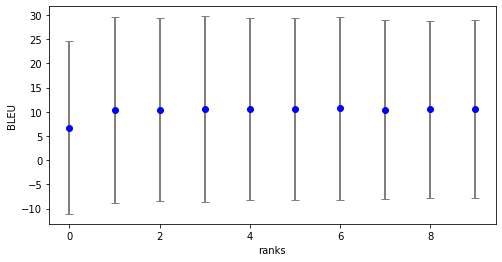

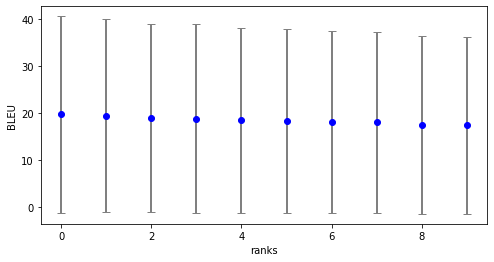

In [102]:
### position scores
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np

def score_all_outputs(output_dict, refs):
    scores = []
    for idx in output_dict:
        cur_ref = refs[idx]
        candidates = output_dict[idx]
        candidates = [item[1] for item in candidates]
        cur_scores = [sacrebleu.sentence_bleu(item, cur_ref).score for item in candidates]
        scores.append(cur_scores)
    return scores

def collect_pos_stats(scores):
    pos_scores = defaultdict(list)
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            pos_scores[j].append(scores[i][j])
    for key in pos_scores:
        pos_scores[key] = np.array(pos_scores[key])
        pos_scores[key] = {
            'mean': np.mean(pos_scores[key]),
            'std': np.std(pos_scores[key]),
        }
    return pos_scores

def plot_errorbar(stats_dict):
    fig,ax=plt.subplots(figsize=(8,4))
    keys = stats_dict.keys()
    means = [stats_dict[key]['mean'] for key in keys]
    errs = [stats_dict[key]['std'] for key in keys]

    ax.errorbar(keys, means,
                yerr=errs,\
                fmt="o",color="blue",ecolor='grey',elinewidth=2,capsize=4)
    ax.set_xlabel('ranks')
    ax.set_ylabel('BLEU')
#     ax.set_xticklabels(col,rotation=45) #设置x轴刻度标签，并使其倾斜45度，不至于重叠

beam_scores = score_all_outputs(dbpe_detok_beam_outputs, refs)
dfstopk_scores = score_all_outputs(dbpe_detok_dfstopk_outputs, refs)

beam_pos_scores = collect_pos_stats(beam_scores)
dfs_pos_scores = collect_pos_stats(dfstopk_scores)

plot_errorbar(dfs_pos_scores)
plot_errorbar(beam_pos_scores)

In [10]:
dfs_pos_scores

defaultdict(list,
            {0: {'mean': 6.7132306522293215, 'std': 17.811058216687815},
             1: {'mean': 10.300752799155397, 'std': 19.201259714289755},
             2: {'mean': 10.453928017204625, 'std': 18.949544628406645},
             3: {'mean': 10.593056072905203, 'std': 19.142995585387304},
             4: {'mean': 10.541437262289291, 'std': 18.775512922301502},
             5: {'mean': 10.63876495103687, 'std': 18.79029130030869},
             6: {'mean': 10.705813530927777, 'std': 18.83584318171147},
             7: {'mean': 10.444280657293916, 'std': 18.549107445177608},
             8: {'mean': 10.475913557725764, 'std': 18.29464152130391},
             9: {'mean': 10.567897049790993, 'std': 18.41172119882995}})

Sum scores!
Average scores!


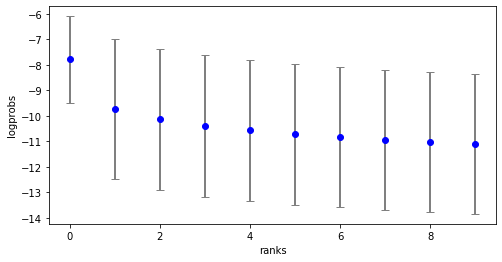

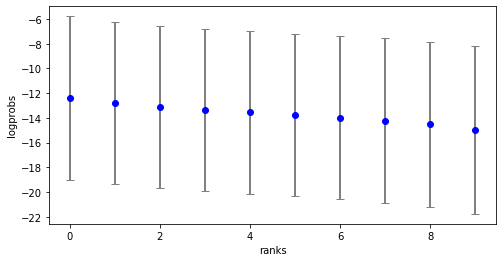

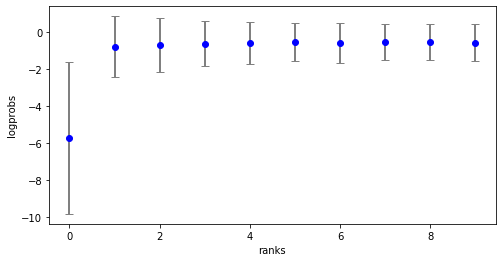

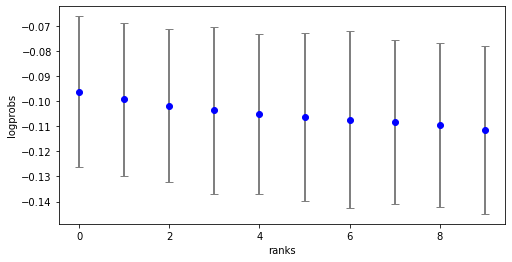

In [103]:
### mean position scores
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np

def extra_logprobs(output_dict):
    scores = []
    for idx in output_dict:
        candidates = output_dict[idx]
#         candidates = [item[1] for item in candidates]
#         cur_scores = [sacrebleu.sentence_bleu(item, cur_ref).score for item in candidates]
        cur_scores = [item[0] for item in candidates]
        scores.append(cur_scores)
    return scores

def avg_logprobs(output_dict):
    scores = []
    for idx in output_dict:
        candidates = output_dict[idx]
#         candidates = [item[1] for item in candidates]
#         cur_scores = [sacrebleu.sentence_bleu(item, cur_ref).score for item in candidates]
        cur_scores = [item[0] for item in candidates]
        lengths = [len(item[1])+1 for item in candidates]
        avg_scores = [cur_scores[i] / lengths[i] for i in range(len(cur_scores))]
        scores.append(avg_scores)
    return scores

def collect_pos_stats(scores):
    pos_scores = defaultdict(list)
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            pos_scores[j].append(scores[i][j])
    for key in pos_scores:
        pos_scores[key] = np.array(pos_scores[key])
        pos_scores[key] = {
            'mean': np.mean(pos_scores[key]),
            'std': np.std(pos_scores[key]),
        }
    return pos_scores

def plot_errorbar(stats_dict):
    fig,ax=plt.subplots(figsize=(8,4))
    keys = stats_dict.keys()
    means = [stats_dict[key]['mean'] for key in keys]
    errs = [stats_dict[key]['std'] for key in keys]

    ax.errorbar(keys, means,
                yerr=errs,\
                fmt="o",color="blue",ecolor='grey',elinewidth=2,capsize=4)
    ax.set_xlabel('ranks')
    ax.set_ylabel('logprobs')

#     ax.set_xticklabels(col,rotation=45) #设置x轴刻度标签，并使其倾斜45度，不至于重叠


print('Sum scores!')
# sum scores
beam_logprobs = extra_logprobs(dbpe_detok_beam_outputs)
dfstopk_logprobs = extra_logprobs(dbpe_detok_dfstopk_outputs)

beam_pos_scores = collect_pos_stats(beam_logprobs)
dfs_pos_scores = collect_pos_stats(dfstopk_logprobs)
plot_errorbar(dfs_pos_scores)
plot_errorbar(beam_pos_scores)

print('Average scores!')
# sum scores
beam_avg = avg_logprobs(beam_outputs)
dfstopk_avg = avg_logprobs(dfs_outputs)

beam_pos_scores = collect_pos_stats(beam_avg)
dfs_pos_scores = collect_pos_stats(dfstopk_avg)
plot_errorbar(dfs_pos_scores)
plot_errorbar(beam_pos_scores)

In [12]:
## oracle ranks && oracle scores

from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np

def score_all_outputs(output_dict, refs):
    scores = []
    for idx in output_dict:
        cur_ref = refs[idx]
        candidates = output_dict[idx]
        candidates = [item[1] for item in candidates]
        cur_scores = [sacrebleu.sentence_bleu(item, cur_ref).score for item in candidates]
        scores.append(cur_scores)
    return scores

def collect_oracle_and_rank(scores):
    ret = []
    for each_scores in scores:
        max_v = float('-inf')
        max_i = -1
        for i in range(len(each_scores)):
            if each_scores[i] > max_v:
                max_v = each_scores[i]
                max_i = i
        ret.append((max_i, max_v))
    return ret

beam_scores = score_all_outputs(dbpe_detok_beam_outputs, refs)
dfstopk_scores = score_all_outputs(dbpe_detok_dfstopk_outputs, refs)

beam_oracle_and_rank = collect_oracle_and_rank(beam_scores)
dfs_oracle_and_rank = collect_oracle_and_rank(dfstopk_scores)

print("Beam oracle rank: {}".format(sum([item[0] for item in beam_oracle_and_rank]) / len(beam_oracle_and_rank)))
print("dfs oracle rank: {}".format(sum([item[0] for item in dfs_oracle_and_rank])/ len(beam_oracle_and_rank)))
print("Beam oracle score: {}".format(sum([item[1] for item in beam_oracle_and_rank])/ len(beam_oracle_and_rank)))
print("dfs oracle score: {}".format(sum([item[1] for item in dfs_oracle_and_rank])/ len(beam_oracle_and_rank)))

Beam oracle rank: 2.261072261072261
dfs oracle rank: 2.7186147186147185
Beam oracle score: 27.982202031245524
dfs oracle score: 20.469624878088066


In [13]:
def extra_logprobs(output_dict):
    scores = []
    for idx in output_dict:
        candidates = output_dict[idx]
#         candidates = [item[1] for item in candidates]
#         cur_scores = [sacrebleu.sentence_bleu(item, cur_ref).score for item in candidates]
        cur_scores = [item[0] for item in candidates]
        scores.append(cur_scores)
    return scores

def mean(l):
    return sum(l) / len(l)



In [14]:
import sklearn
import numpy as np

np_beam_scores = [np.array(item) for item in beam_scores]
np_dfs_scores = [np.array(item) for item in dfstopk_scores]
beam_logprobs = extra_logprobs(dbpe_detok_beam_outputs)
dfstopk_logprobs = extra_logprobs(dbpe_detok_dfstopk_outputs)
np_beam_logprob = [np.array(item) for item in beam_logprobs]
np_dfs_logprob = [np.array(item) for item in dfstopk_logprobs]

def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    DCG @k : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    """Normalized discounted cumulative gain (NDCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------
    NDCG @k : float
    """
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    if actual == 0:
        ret = 0
    else:
        ret = actual / best
    return ret

def compute_ndcg_over_list(score_list, logprob_list):
    ndcgs = []
    for i in range(len(score_list)):
        cur_score = score_list[i]
        cur_logprob = logprob_list[i]
        ndcgs.append(ndcg_score(cur_score, cur_logprob))
    return ndcgs

beam_ndcgs = compute_ndcg_over_list(np_beam_scores, np_beam_logprob)
dfs_ndcgs = compute_ndcg_over_list(np_dfs_scores, np_dfs_logprob)

## Define Model Error Metrics

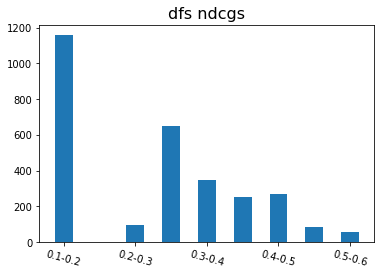

In [99]:
def paint_ndcg_cnt(all_scores, title):
    all_bins = list(range(0, 10))
    all_bins = [item / 10 for item in all_bins]

    all_bins_cnts = [0] * 9
    for score in all_scores:
        for i in range(len(all_bins) - 1):
            if score >= all_bins[i] and score < all_bins[i+1]:
                all_bins_cnts[i] += 1
    labels = ["{}-{}".format(all_bins[i], all_bins[i+1]) for i in range(len(all_bins)-1)]
    fig, ax = plt.subplots()
    ax.bar(list(range(len(all_bins_cnts))), all_bins_cnts, width=0.5)
    ax.set_xticklabels(labels, rotation=-15)
    ax.set_title(title,fontsize=16)

    plt.show()

# paint_ndcg_cnt(beam_ndcgs, "beam ndcgs")
paint_ndcg_cnt(dfs_ndcgs, "dfs ndcgs")


In [100]:
def mean_reciprocal_rank(rs, sum_local=False):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = [np.asarray(r).nonzero()[0] for r in rs]
    if sum_local is True:
        return np.mean([np.sum(1. / (r + 1)) if r.size else 0. for r in rs])
    else:
        return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def compute_mrr(score_list, threshold=40):
    cnt = 0
    rs = []
    for score in score_list:
        cur_rs = (score > threshold).astype(int)
        rs.append(cur_rs)
    mr = mean_reciprocal_rank(rs, sum_local=False)
    return mr

# compute_mrr(np_beam_scores, threshold=50)
compute_mrr(np_dfs_scores, threshold=50)

0.08080953438096296

## Define Search Error Metrics

In [ ]:
"""
## from score's perspective && from output's perspective
1. from score's perspective --> Suitable for decoding methods that don't modify the output scores (w/o other regualrization).
    - If we have a decoding method A (e.g., beam search), we have following evaluation procotols.
    - 1. score diff, the score difference between mode and output of A.
    - 2. score mean diff
    - 3. exact score distribution vs outputs score distribution
2. from output's perspective --> Suitable for any decoding methods.
    - Evaluate outputs by its properties.
    - 1. length distribution: absolute length, relative length
    - 2. matching stats: outputs in dfs, outputs' ranks in dfs
    - 3. similarity: bleu score or edit distance for exact outputs and decoding outputs
"""

## Other detailed research of model errors